Seed 23463


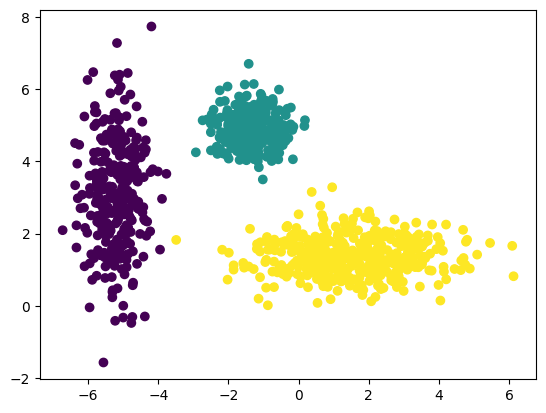

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random

def create_2d_test_data(means, scales, weights,
                        min_distance=0, num_samples=1000,
                        return_center_assignment=True):

    dimensions = len(means[0])

    if len(scales.shape) == 1:
        scales = scales[:, np.newaxis]

    def are_centers_far_apart():
        for i in range(len(means)):
            for j in range(i + 1, len(means)):
                if np.linalg.norm(means[i] - means[j]) < min_distance:
                    return False
        return True

    while not are_centers_far_apart():
        for i in range(len(means)):
            for j in range(i + 1, len(means)):
                while np.linalg.norm(means[i] - means[j]) < min_distance:
                    means[j] += np.random.uniform(-0.5, 0.5, size=dimensions)


    sel = np.random.choice(means.shape[0], size=num_samples, replace=True,
                           p=weights / weights.sum())

    sel = sel[sel.argsort()]
    data = means[sel, :] + np.random.normal(size=(num_samples, dimensions)) * scales[sel, :]

    data -= data.mean()

    if return_center_assignment:
        return data, sel
    else:
        return data


n_centers = 3
seed = random.randint(0, 100000)
print('Seed', seed)
np.random.seed(31807)
data, labels = create_2d_test_data(means=10*np.random.random(size=(n_centers, 2)),
                                 scales = np.random.choice([0.5, 1.5], size=(n_centers,2)),
                                 weights=np.array([0.3, 0.3, 0.4]),
                                 min_distance=1,
                                #  weights=0.25 + 0.75*np.random.random(size=n_centers),
                                 num_samples=1000)

data[labels > 0, 1] += 4
data[labels > 0, 0] -= 1.5
data[labels == 1, 1] -= 0.5


import sys
sys.path.append("..")
from tangles.util.matrix_order import linear_similarity_from_dist_matrix
from scipy.spatial import distance_matrix
distances = distance_matrix(data, data)

sim_matrix = linear_similarity_from_dist_matrix(distances, margin=1.5, sparse_mat=False)
order_fun = lambda seps: -(seps * (sim_matrix @ seps)).sum(axis=0)


In [2]:
from tangles.convenience import search_tangles, DefaultProgressCallback
k=4
S_ax = -np.ones((data.shape[0], 2*k), dtype=np.int8)

x_splits = np.linspace(data[:,0].min(), data[:,0].max(), k+2)[1:-1]
y_splits = np.linspace(data[:,1].min(), data[:,1].max(), k+2)[1:-1]
for i,t in enumerate(x_splits):
    S_ax[data[:,0]<t,i] = 1
for i,t in enumerate(y_splits):
    S_ax[data[:,1]<t,k+i] = 1

from tangles.util import unique_cols
S_ax = unique_cols(S_ax*S_ax[0:1,:])
cost_arg_sort = order_fun(S_ax).argsort()
S_ax = S_ax[:, cost_arg_sort]

print(f"There are {S_ax.shape[1]} unique features left")
agreement = 250

S_ax[: ,1:4] = 1 - S_ax[: ,1:4]
S_ax[: ,6:] = 1 - S_ax[: ,6:]


tangles_ = search_tangles(S_ax, min_agreement=agreement, progress_callback=DefaultProgressCallback(show_info_while_running=False))

There are 8 unique features left
[ tree height=8, number of tangles=3, limit=207.0 ]: appending finished                                                                               


/tmp/ipykernel_328380/3300599463.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(data[:,0],data[:,1], s=0.1, vmin=-1000, vmax=1, color='blue')


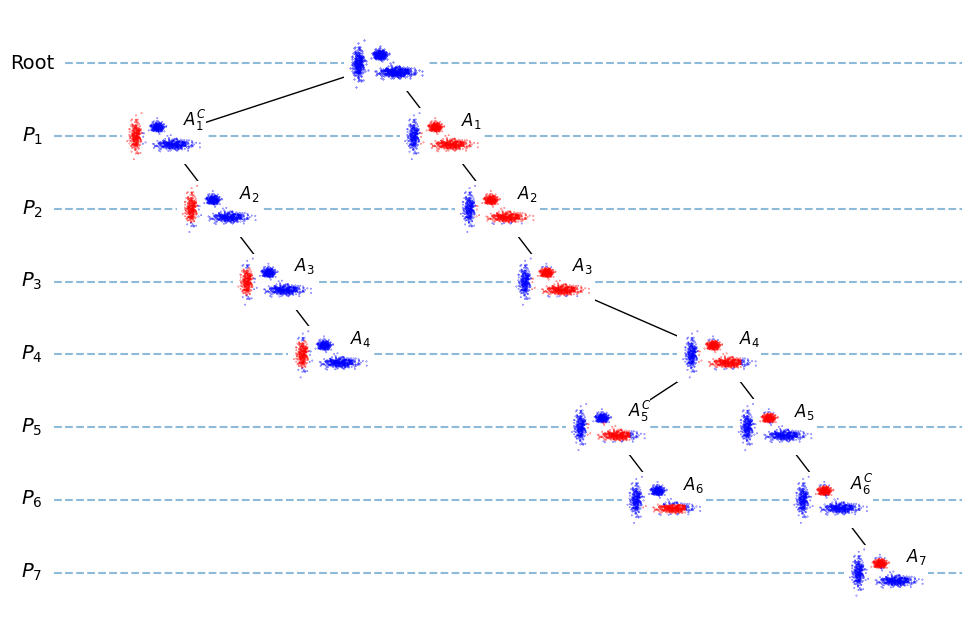

AttributeError: PathCollection.set() got an unexpected keyword argument 'figsize'

<Figure size 640x480 with 0 Axes>

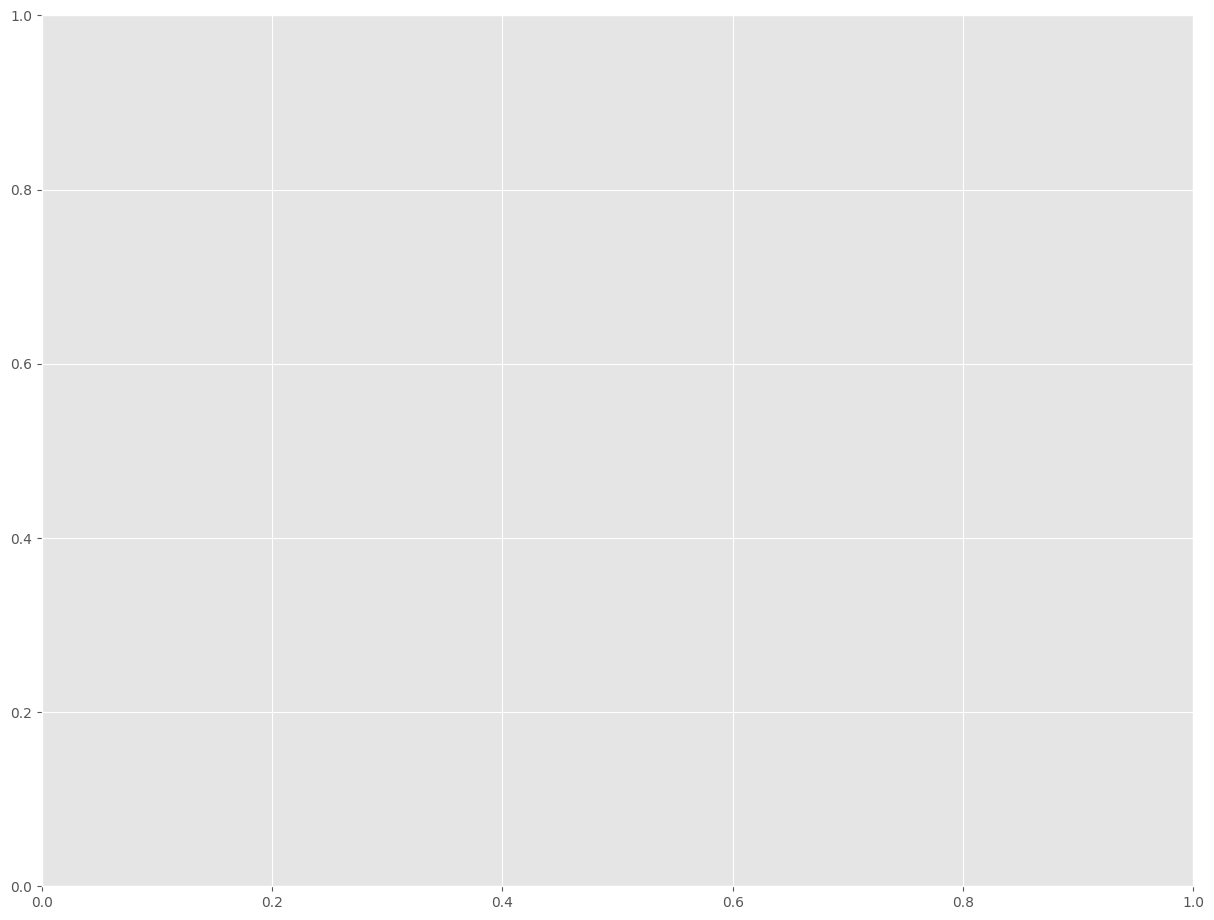

In [13]:


import importlib
from tangles.util.tree import BinTreeNetworkX
import tangles.util.tree


importlib.reload(tangles.util.tree)

# from tangles.util.tree import BinTreeNetworkX
from tangles.analysis import tangle_score
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap



c = ["lightgray", "lightgray", "blue", "red"]
v = [0,0.6,0.8,1.0]
cmap=LinearSegmentedColormap.from_list('mymap',list(zip(v,c)))

plt.style.use('default')

def draw_tangle(G, node_id, ax):
    bin_tree_node = G.nodes[node_id][BinTreeNetworkX.node_attr_bin_tree_node]
    min_p, max_p = (data[:,0].min()-1, data[:,1].min()-1), (data[:,0].max()+1, data[:,1].max()+1)
    ax.set_xlim(xmin=min_p[0], xmax=max_p[0])
    ax.set_ylim(ymin=min_p[1], ymax=max_p[1])
    ax.add_patch(patches.Rectangle(min_p, max_p[0]-min_p[0], max_p[1]-min_p[1], edgecolor='none', facecolor='w'))

    if bin_tree_node.parent is None:
        ax.scatter(data[:,0],data[:,1], s=0.1, vmin=-1000, vmax=1, color='blue')
    else:
        path = np.array(bin_tree_node.path_from_root_indicator())[np.newaxis,:]
        scores = tangle_score(path, tangles_.tree.sep_ids[:path.shape[1]], tangles_.sep_sys).reshape(-1)
        c = ['red' if s == scores.max() else 'blue' for s in scores]
        ax.scatter(data[:,0],data[:,1], c=c, s=0.05)

        i = path.shape[1]
        text_x = max_p[0] - 4
        text_y = (min_p[1] + max_p[1])
        text = (r"$A_{{{}}}$".format(i)
                if bin_tree_node.path_from_root_indicator()[-1] == -1
                else r"$A_{{{}}}^{{C}}$".format(i))
        ax.text(text_x, text_y, text,
                fontsize=12, color="black", verticalalignment="center")

def get_all_tangles(tree):
    all_tangles = []
    for _, level in tree._levels(tree.root, agreement):
        all_tangles.extend(level)

    return all_tangles

# bintree = BinTreeNetworkX(tangles.tree.maximal_tangles(agreement=agreement, include_splitting='levels'))
bintree = BinTreeNetworkX(get_all_tangles(tangles_.tree))

fig, ax = plt.subplots(1,1,figsize=(12,8))
bintree.draw(draw_node_label_func=draw_tangle, draw_edge_label_func=None, ax=ax, node_label_size=0.07,
        axhline_kwargs={'alpha': 0.5}, level_label_width=1,
             draw_levels=True, level_label_func=lambda l: r"$P_{{{0}}}$".format(l)
                                                if l != 0 else "Root")
ax.set_frame_on(False)


fig.savefig("tangle_search_tree.png", dpi=300, bbox_inches='tight', transparent=True)  # Save at 300 DPI


plt.show()




In [5]:
colors = ['red', 'blue', 'green']

with open('data.csv', 'w') as f:
    f.write('x,y,color\n')
    for i in range(data.shape[0]):
        f.write(f'{data[i,0]},{data[i,1]},{colors[labels[i]]}\n')

x -4.156050703040774
y 0.2912948074163242
y 5.876092456674818
x 3.5594322417051263
y 4.01449324025532
y 2.152894023835822
x 0.987604593456493
x -1.5842230547921403


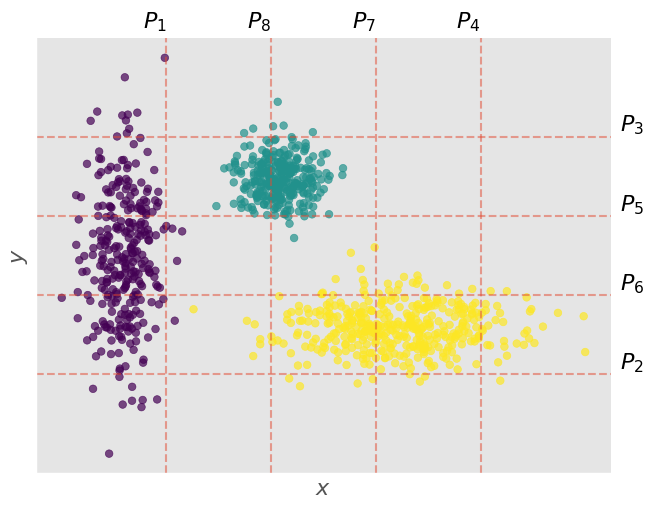

In [73]:
import matplotlib.pyplot as plt

# Assuming `data` and `labels` are already defined
plt.style.use('ggplot')

# Create the figure with the specified size
plt.figure(figsize=(14.86 / 2, 11.31 / 2))


# Scatter plot with adjusted marker size and transparency
plt.scatter(data[:, 0], data[:, 1], c=labels, alpha=0.7, s=30)  # Increase 's' for larger markers

ax = plt.gca()
max_x = ax.get_xlim()[1]
max_y = ax.get_ylim()[1]

# Remove the line on the top and right
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Remove x and y ticks
plt.xticks([])
plt.yticks([])

plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$y$', fontsize=16)
# Show the plot

# Assuming cost_arg_sort, y_splits, x_splits, k are already defined

for j,  i in enumerate(cost_arg_sort):
    j = j + 1
    if i >= k:
        # Plot horizontal line
        plt.axhline(y=y_splits[i-k], alpha=0.5, linestyle='--')

        # Add text just to the top-right of the line
        plt.text(x=max_x * 1.03, y=y_splits[i-k],
                 s=r"$P_{" + str(j) + "}$", fontsize=16, verticalalignment='bottom')

        print('y', y_splits[i-k])
    else:
        # Plot vertical line
        plt.axvline(x=x_splits[i], alpha=0.5, linestyle='--')

        # Add text just to the top-right of the line
        plt.text(x=x_splits[i], y=max_y * 1.03,
                 s=r"$P_{" + str(j) + "}$", fontsize=16, horizontalalignment='right')

        print('x', x_splits[i])

# Show the plot
plt.show()


x -4.156050703040774
y 0.2912948074163242
y 5.876092456674818
x 3.5594322417051263
y 4.01449324025532
y 2.152894023835822
x 0.987604593456493
x -1.5842230547921403


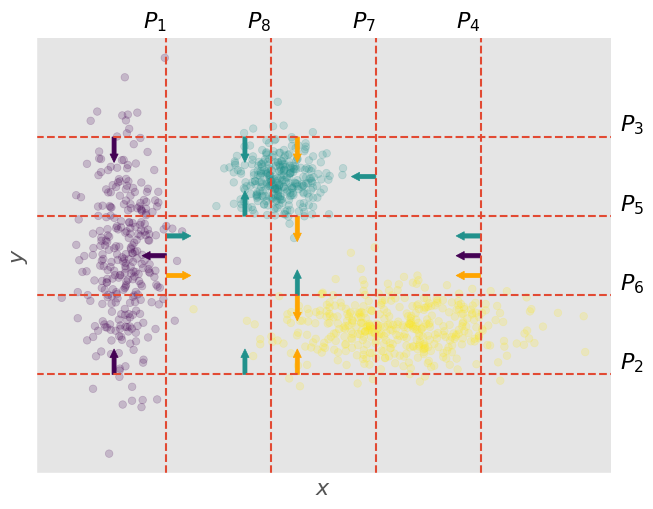

In [ ]:
import matplotlib.pyplot as plt

x_offshift = (x_splits[1] - x_splits[0]) / 2
y_offshift = (y_splits[1] - y_splits[0]) / 2
x_offshift_third = (x_splits[1] - x_splits[0]) / 3
y_offshift_third = (y_splits[1] - y_splits[0]) / 3
x_offshift_fourth = (x_splits[1] - x_splits[0]) / 4
y_offshift_fourth = (y_splits[1] - y_splits[0]) / 4

# Assuming `data` and `labels` are already defined
plt.style.use('ggplot')

# Create the figure with the specified size
plt.figure(figsize=(14.86 / 2, 11.31 / 2))


purple = '#440154'
green = '#21918c'
yellow = '#fde725'

# Scatter plot with adjusted marker size and transparency

plt.scatter(data[:, 0], data[:, 1], c=labels
            , alpha=0.2, s=30, )

ax = plt.gca()
max_x = ax.get_xlim()[1]
max_y = ax.get_ylim()[1]

# Remove the line on the top and right
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Remove x and y ticks
plt.xticks([])
plt.yticks([])

plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$y$', fontsize=16)
# Show the plot

# Assuming cost_arg_sort, y_splits, x_splits, k are already defined

for j,  i in enumerate(cost_arg_sort):
    j = j + 1
    if i >= k:
        # Plot horizontal line
        plt.axhline(y=y_splits[i-k], alpha=1, linestyle='--')

        # Add text just to the top-right of the line
        plt.text(x=max_x * 1.03, y=y_splits[i-k],
                 s=r"$P_{" + str(j) + "}$", fontsize=16, verticalalignment='bottom')

        print('y', y_splits[i-k])
    else:
        # Plot vertical line
        plt.axvline(x=x_splits[i], alpha=1, linestyle='--')

        # Add text just to the top-right of the line
        plt.text(x=x_splits[i], y=max_y * 1.03,
                 s=r"$P_{" + str(j) + "}$", fontsize=16, horizontalalignment='right')

        print('x', x_splits[i])

def get_x(order):
    return x_splits[cost_arg_sort[order]]

def get_y(order):
    return y_splits[cost_arg_sort[order] - k]

def arrow(x=0, y=0, dx=0, dy=0, color='black'):

    plt.arrow(x=x, y=y, dx=dx * 0.8, dy=dy * 0.8, width=0.1, head_width=0.2, head_length=0.2, fc=color, ec=color)

# Purple tangle arrows
arrow(get_x(0), y_splits[1:3].mean(), dx=-0.5, color=purple)
arrow(x_splits[0] - x_offshift, y=get_y(1), dy=0.5, color=purple)
arrow(x_splits[0] - x_offshift, y=get_y(2), dy=-0.5, color=purple)
arrow(get_x(3), y_splits[1:3].mean(), dx=-0.5, color=purple)

# Green tangle arrows
arrow(get_x(0), y_splits[1] + y_offshift_fourth, dx=0.5, color='orange')
arrow(get_x(0), y_splits[2] - y_offshift_fourth, dx=0.5, color=green)

arrow(x_splits[1] - x_offshift_fourth, y=get_y(1), dy=0.5, color=green)
arrow(x_splits[1] + x_offshift_fourth, y=get_y(1), dy=0.5, color='orange')

arrow(x_splits[1] - x_offshift_fourth, y=get_y(2), dy=-0.5, color=green)
arrow(x_splits[1] + x_offshift_fourth, y=get_y(2), dy=-0.5, color='orange')
arrow(get_x(3), y_splits[1:3].mean() + y_offshift_fourth, dx=-0.5, color=green)
arrow(get_x(3), y_splits[1:3].mean() - y_offshift_fourth, dx=-0.5, color='orange')

arrow(x_splits[1] - x_offshift_fourth, y=get_y(4), dy=0.5, color=green)
arrow(x_splits[1] + x_offshift_fourth, y=get_y(4), dy=-0.5, color='orange')

arrow(x_splits[1] + x_offshift_fourth, y=get_y(5), dy=-0.5, color='orange')
arrow(x_splits[1] + x_offshift_fourth, y=get_y(5), dy=0.5, color=green)

arrow(get_x(6), y_splits[2:4].mean(), dx=-0.5, color=green)
# Show the plot
plt.show()


In [80]:
y_splits

array([0.29129481, 2.15289402, 4.01449324, 5.87609246])

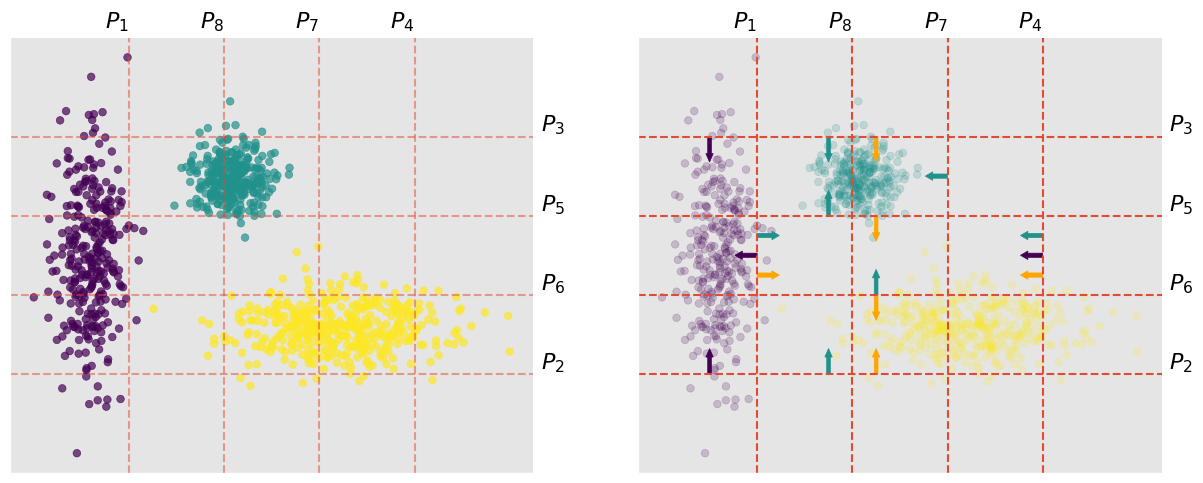

In [130]:

import matplotlib.pyplot as plt
plt.style.use(
    'ggplot'
)
# Create a figure with subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(14.86, 11.31 / 2))

# First plot (original)
ax[0].scatter(data[:, 0], data[:, 1], c=labels, alpha=0.7, s=30)
max_x = ax[0].get_xlim()[1]
max_y = ax[0].get_ylim()[1]

# Remove the line on the top and right for first plot
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

# Remove x and y ticks for first plot
ax[0].set_xticks([])
ax[0].set_yticks([])

# Plot lines and add text in the first plot
for j, i in enumerate(cost_arg_sort):
    j = j + 1
    if i >= k:
        ax[0].axhline(y=y_splits[i-k], alpha=0.5, linestyle='--')
        ax[0].text(x=max_x * 1.03, y=y_splits[i-k],
                 s=r"$P_{" + str(j) + "}$", fontsize=16, verticalalignment='bottom')
    else:
        ax[0].axvline(x=x_splits[i], alpha=0.5, linestyle='--')
        ax[0].text(x=x_splits[i], y=max_y * 1.03,
                 s=r"$P_{" + str(j) + "}$", fontsize=16, horizontalalignment='right')

# Second plot (modified)
ax[1].scatter(data[:, 0], data[:, 1], c=labels, alpha=0.2, s=30)
max_x = ax[1].get_xlim()[1]
max_y = ax[1].get_ylim()[1]

# Remove the line on the top and right for second plot
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

# Remove x and y ticks for second plot
ax[1].set_xticks([])
ax[1].set_yticks([])


# Plot lines and add text in the second plot
for j, i in enumerate(cost_arg_sort):
    j = j + 1
    if i >= k:
        ax[1].axhline(y=y_splits[i-k], alpha=1, linestyle='--')
        ax[1].text(x=max_x * 1.03, y=y_splits[i-k],
                 s=r"$P_{" + str(j) + "}$", fontsize=16, verticalalignment='bottom')
    else:
        ax[1].axvline(x=x_splits[i], alpha=1, linestyle='--')
        ax[1].text(x=x_splits[i], y=max_y * 1.03,
                 s=r"$P_{" + str(j) + "}$", fontsize=16, horizontalalignment='right')

# Function to draw arrows
def arrow(ax, x=0, y=0, dx=0, dy=0, color='black'):
    ax.arrow(x=x, y=y, dx=dx * 0.8, dy=dy * 0.8, width=0.1, head_width=0.2, head_length=0.2, fc=color, ec=color)

# Arrows for the second plot
arrow(ax[1], get_x(0), y_splits[1:3].mean(), dx=-0.5, color=purple)
arrow(ax[1], x_splits[0] - x_offshift, y=get_y(1), dy=0.5, color=purple)
arrow(ax[1], x_splits[0] - x_offshift, y=get_y(2), dy=-0.5, color=purple)
arrow(ax[1], get_x(3), y_splits[1:3].mean(), dx=-0.5, color=purple)

# More arrows for the second plot
arrow(ax[1], get_x(0), y_splits[1] + y_offshift_fourth, dx=0.5, color='orange')
arrow(ax[1], get_x(0), y_splits[2] - y_offshift_fourth, dx=0.5, color=green)

arrow(ax[1], x_splits[1] - x_offshift_fourth, y=get_y(1), dy=0.5, color=green)
arrow(ax[1], x_splits[1] + x_offshift_fourth, y=get_y(1), dy=0.5, color='orange')

arrow(ax[1], x_splits[1] - x_offshift_fourth, y=get_y(2), dy=-0.5, color=green)
arrow(ax[1], x_splits[1] + x_offshift_fourth, y=get_y(2), dy=-0.5, color='orange')
arrow(ax[1], get_x(3), y_splits[1:3].mean() + y_offshift_fourth, dx=-0.5, color=green)
arrow(ax[1], get_x(3), y_splits[1:3].mean() - y_offshift_fourth, dx=-0.5, color='orange')

arrow(ax[1], x_splits[1] - x_offshift_fourth, y=get_y(4), dy=0.5, color=green)
arrow(ax[1], x_splits[1] + x_offshift_fourth, y=get_y(4), dy=-0.5, color='orange')

arrow(ax[1], x_splits[1] + x_offshift_fourth, y=get_y(5), dy=-0.5, color='orange')
arrow(ax[1], x_splits[1] + x_offshift_fourth, y=get_y(5), dy=0.5, color=green)

arrow(ax[1], get_x(6), y_splits[2:4].mean(), dx=-0.5, color=green)

# Show the plots
plt.show()
